In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

In [2]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)[:45] # select the top 50 symbols
len(subset_symbols),subset_symbols[1]

(45, 'XRP')

In [3]:
top50symbols_usdt = [s+"USDT" for s in subset_symbols]

In [4]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(190)):
    with open(f"2_0_0_analysisdata/2_0_3_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list2 = pickle.load(f)
    dfmpl_list = [ d for d in dfmpl_list2 if d[1] in top50symbols_usdt]
    dfmpl_list_list.append( dfmpl_list.copy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:16<00:00, 11.33it/s]


In [5]:
%%time
for symm in tqdm.tqdm(subset_symbols):
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    if not all(np.diff(df__.index,2).astype(float)==0):
        print(symm)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 21.28it/s]

CPU times: total: 1.36 s
Wall time: 2.12 s


# concat the dfs, store into a list of dfs, also store a list of corresponding symbols

In [6]:
dfmpl_list = []

for idd,symm in enumerate(tqdm.tqdm(subset_symbols[:50])):
    #if idd<110:continue
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    dfmpl_list.append( (df__.copy(),symm,idd) ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 23.63it/s]


In [7]:
dfmpl,symm,idd = dfmpl_list[-1]
dfmpl,symm,idd,len(dfmpl_list)

(                      Open   High    Low  Close   Volume
 Date                                                    
 2023-03-30 04:01:00  5.761  5.761  5.749  5.752  2492.93
 2023-03-30 04:02:00  5.751  5.751  5.745  5.746   940.27
 2023-03-30 04:03:00  5.748  5.748  5.743  5.747  3119.68
 2023-03-30 04:04:00  5.748  5.756  5.748  5.755  7235.32
 2023-03-30 04:05:00  5.756  5.758  5.756  5.757  5062.05
 ...                    ...    ...    ...    ...      ...
 2023-08-09 02:36:00  4.153  4.155  4.152  4.155   882.54
 2023-08-09 02:37:00  4.155  4.155  4.153  4.155  2082.64
 2023-08-09 02:38:00  4.154  4.155  4.152  4.153   287.02
 2023-08-09 02:39:00  4.155  4.157  4.153  4.154  1180.63
 2023-08-09 02:40:00  4.154  4.156  4.153  4.153  1425.18
 
 [190000 rows x 5 columns],
 'FILUSDT',
 44,
 43)

In [8]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
vol = (dfmpl.Volume*dfmpl.Open).values

In [9]:
vol

array([14361.76973,  5407.49277, 17931.92064, ...,  1192.28108,
        4905.51765,  5920.19772])

In [10]:
np.percentile(vol,99)

169885.1245775001

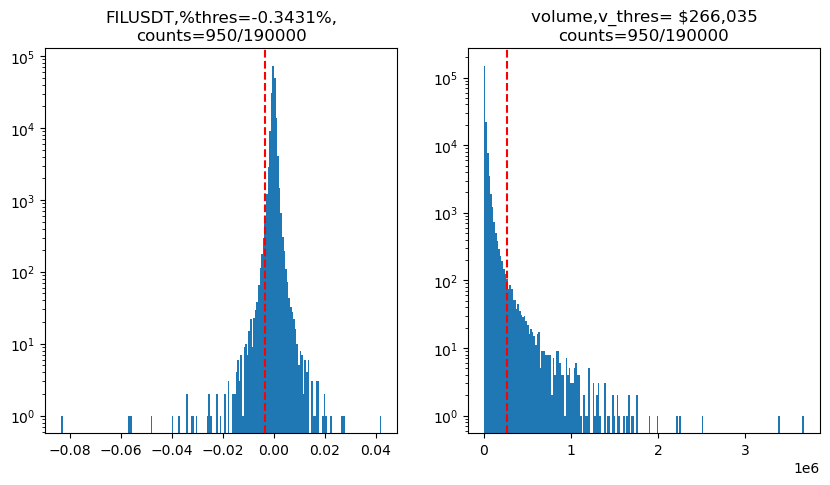

In [11]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
#percentile_threshold = np.percentile(v,99.9)
percentile_threshold = np.percentile(v,0.5)
ax.hist(v,bins=200);
ax.axvline(percentile_threshold,ls="--",c="r")
ax.set_title(f"{symm},%thres={percentile_threshold:.4%},\ncounts={sum(v<percentile_threshold)}/{len(v)}")
ax.set_yscale("log")
ax=axx[1]
ax.hist(vol,bins=200);
vol_threshold = np.percentile(vol,99.5)
ax.axvline(vol_threshold,ls="--",c="r")
ax.set_title(f"volume,v_thres= ${vol_threshold:3,g}\ncounts={sum(vol>vol_threshold)}/{len(vol)}")
ax.set_yscale("log")

# when price falls twice in a row, 

In [12]:
paramsWin = (-0.00689655,-0.00862069,1000000,2689655) # high%win params
paramsLowSD = (-0.00689655,-0.00172414,2689655,4379310) #lowSD 
#paramsWin = (-0.0049655,0.3,2689655,4379310) #testing

In [13]:
import random

In [14]:
%%time 
collated_data_list = []
all_locs = [] 
    
for dfmpl, symb, _ in tqdm.tqdm(dfmpl_list):
    def validate_df(loc, df_v, v0_thres, v1_thres):
        v0 = df_v[loc, 0] * df_v[loc, 4]
        v1 = df_v[loc + 1, 0] * df_v[loc + 1, 4]
        return v0 > v0_thres and v1 > v1_thres
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
#     threshold1 = -0.0082#np.percentile(v,1)
#     threshold2 = -0.005# np.percentile(v,2)
#     v0_thres = np.percentile(vol,99)
#     v1_thres = np.percentile(vol,98)
    threshold1,threshold2,v0_thres,v1_thres = paramsWin
    df_v = dfmpl.values
    changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0] #open high low close volume
    a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
    locs = np.where(a4_1)[0]
    if locs.size == 0: continue
    chosen_locs = [loc for loc in locs if validate_df(loc, df_v, v0_thres, v1_thres)and loc<(190000-5)]
    if len(chosen_locs)==0:continue
    #[trade_locs.append(f"{loc}_{symb}") for loc in chosen_locs]
    collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
    [all_locs.append(loc)for loc in chosen_locs]
    collated_data_list.append(collated_data) 
                
collated_data = np.vstack(collated_data_list)
collated_data.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 115.72it/s]

CPU times: total: 203 ms
Wall time: 378 ms


(85, 5)

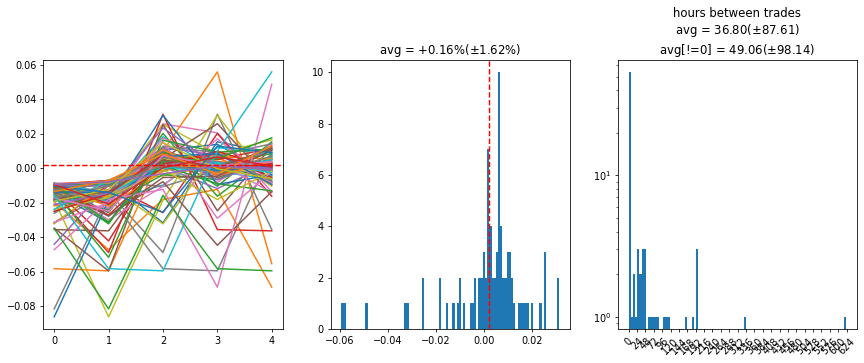

In [15]:
fig,axx=plt.subplots(1,3,figsize=(15,5),dpi=70)
ax=axx[0]
ax.plot(collated_data.T[:,random.sample(range(collated_data.shape[0]),min(200,collated_data.shape[0]))])
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")
ax=axx[2]
hours_between_trades=np.diff(sorted(all_locs))/60
ax.hist(hours_between_trades,bins=100);
strr="hours between trades"
strr+=f"\navg = {np.mean(hours_between_trades):.2f}($\pm${np.std(hours_between_trades):.2f})"
strr+=f"\navg[!=0] = {np.mean(hours_between_trades[hours_between_trades!=0]):.2f}($\pm${np.std(hours_between_trades[hours_between_trades!=0]):.2f})"
ax.set_title(strr)
ax.set_yscale("log")
ax.set_xticks(np.arange(0,max(hours_between_trades)+24,24))
ax.set_xticklabels([f"{n:.0f}" for n in np.arange(0,max(hours_between_trades)+24,24)],rotation=45);

In [16]:
dfmpl,symm,idd = dfmpl_list[0]
dfmpl,symm,idd,len(dfmpl_list)

(                         Open      High       Low     Close    Volume
 Date                                                                 
 2023-03-30 04:01:00  28393.70  28393.71  28361.35  28370.21  64.04108
 2023-03-30 04:02:00  28370.21  28370.21  28356.35  28356.41  35.64334
 2023-03-30 04:03:00  28356.41  28378.30  28356.23  28378.30  24.75670
 2023-03-30 04:04:00  28378.30  28434.72  28378.29  28432.80  79.01198
 2023-03-30 04:05:00  28432.80  28438.06  28432.44  28434.82  40.37953
 ...                       ...       ...       ...       ...       ...
 2023-08-09 02:36:00  29856.02  29864.55  29848.00  29860.00  31.82357
 2023-08-09 02:37:00  29859.99  29862.86  29858.00  29858.01  13.21206
 2023-08-09 02:38:00  29858.00  29858.01  29841.31  29841.32  22.94939
 2023-08-09 02:39:00  29841.31  29856.24  29841.31  29849.99  42.01561
 2023-08-09 02:40:00  29850.00  29867.47  29849.98  29857.00  53.22724
 
 [190000 rows x 5 columns],
 'BTCUSDT',
 0,
 43)

C:\Users\aatan\anaconda3\envs\cryt310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


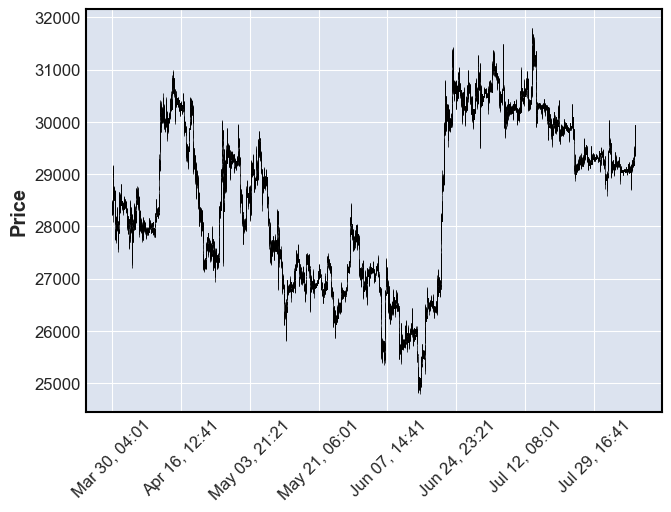

In [17]:
mpf.plot(dfmpl)

In [192]:
import pandas_ta as ta
import talib
from talib import MA_Type

In [236]:

upper, middle, lower = talib.BBANDS(dfmpl.Close,timeperiod=50, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl.Close,timeperiod=50)
change = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).rolling(4).mean()
momen = talib.MOM(dfmpl.Close,timeperiod=40)
momen_rolling = momen.rolling(30).mean()
momen_rolling40 = momen.rolling(40).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl.Close,timeperiod=30,fastk_period=25,fastd_period=15)

In [237]:
potential_candidates = np.where(momen<-450)[0]
#potential_candidates = np.where(change<-0.002)[0]
#potential_candidates

In [238]:
potential_candidates[:-1][np.diff( potential_candidates )>4]

array([   462,   1295,   1300,   1314,   2145,   6106,   7214,   7261,
        22770,  26219,  26853,  29568,  30444,  33078,  33100,  40345,
        40653,  46456,  56504,  56509,  57492,  60353,  60563,  60571,
        62538,  71894,  79661,  80285,  89820,  89835,  97715, 104191,
       104219, 105025, 110885, 110943, 118021, 120808, 122098, 123634,
       127040, 133574, 142100, 142232, 142239, 148443, 148454, 148462,
       154024, 162414], dtype=int64)

In [239]:
np.mean([d for d in np.diff(np.where(momen<-450)[0]) if d>1])/60/24

1.5254477339181287

In [229]:
inddex_of_frame = 26219 
momen.iloc[inddex_of_frame-20:inddex_of_frame+5]

Date
2023-04-17 08:40:00   -437.56
2023-04-17 08:41:00   -445.83
2023-04-17 08:42:00   -408.51
2023-04-17 08:43:00   -379.68
2023-04-17 08:44:00   -396.84
2023-04-17 08:45:00   -395.67
2023-04-17 08:46:00   -416.70
2023-04-17 08:47:00   -378.90
2023-04-17 08:48:00   -413.66
2023-04-17 08:49:00   -414.10
2023-04-17 08:50:00   -424.25
2023-04-17 08:51:00   -439.59
2023-04-17 08:52:00   -449.86
2023-04-17 08:53:00   -443.70
2023-04-17 08:54:00   -427.40
2023-04-17 08:55:00   -381.84
2023-04-17 08:56:00   -419.20
2023-04-17 08:57:00   -389.62
2023-04-17 08:58:00   -389.70
2023-04-17 08:59:00   -395.32
2023-04-17 09:00:00   -461.03
2023-04-17 09:01:00   -415.33
2023-04-17 09:02:00   -377.03
2023-04-17 09:03:00   -339.43
2023-04-17 09:04:00   -319.61
dtype: float64

In [197]:
inddex_of_frame

7213

In [224]:
for indexx, difff in zip(potential_candidates[40:150],np.diff(potential_candidates)[40:150]):
    if difff==1:continue
    print(indexx,difff)

2145 3957
6102 2
6106 1108
7214 46
7261 15509
22770 3449
26219 634
26853 2676
29568 872
30444 2622
33073 2
33076 2
33078 12
33100 7181


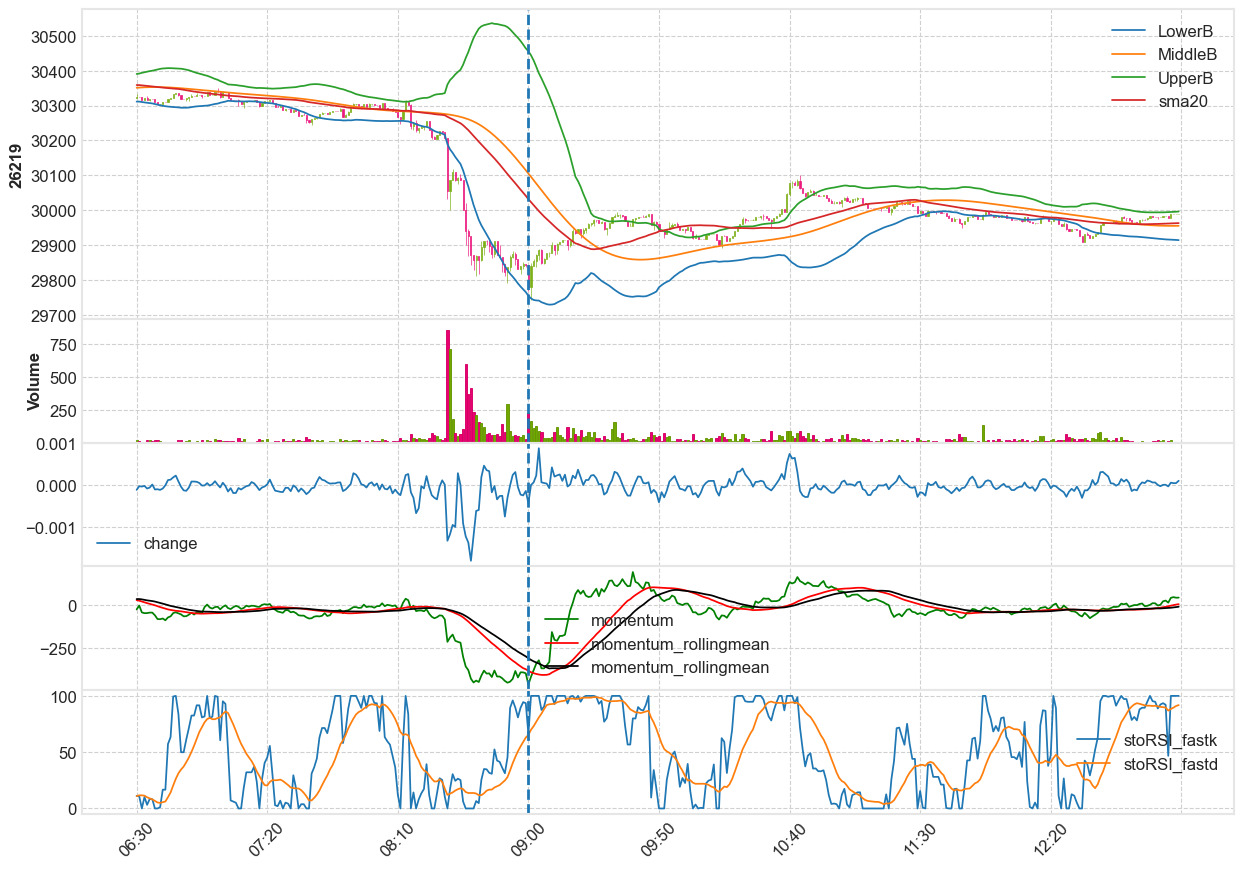

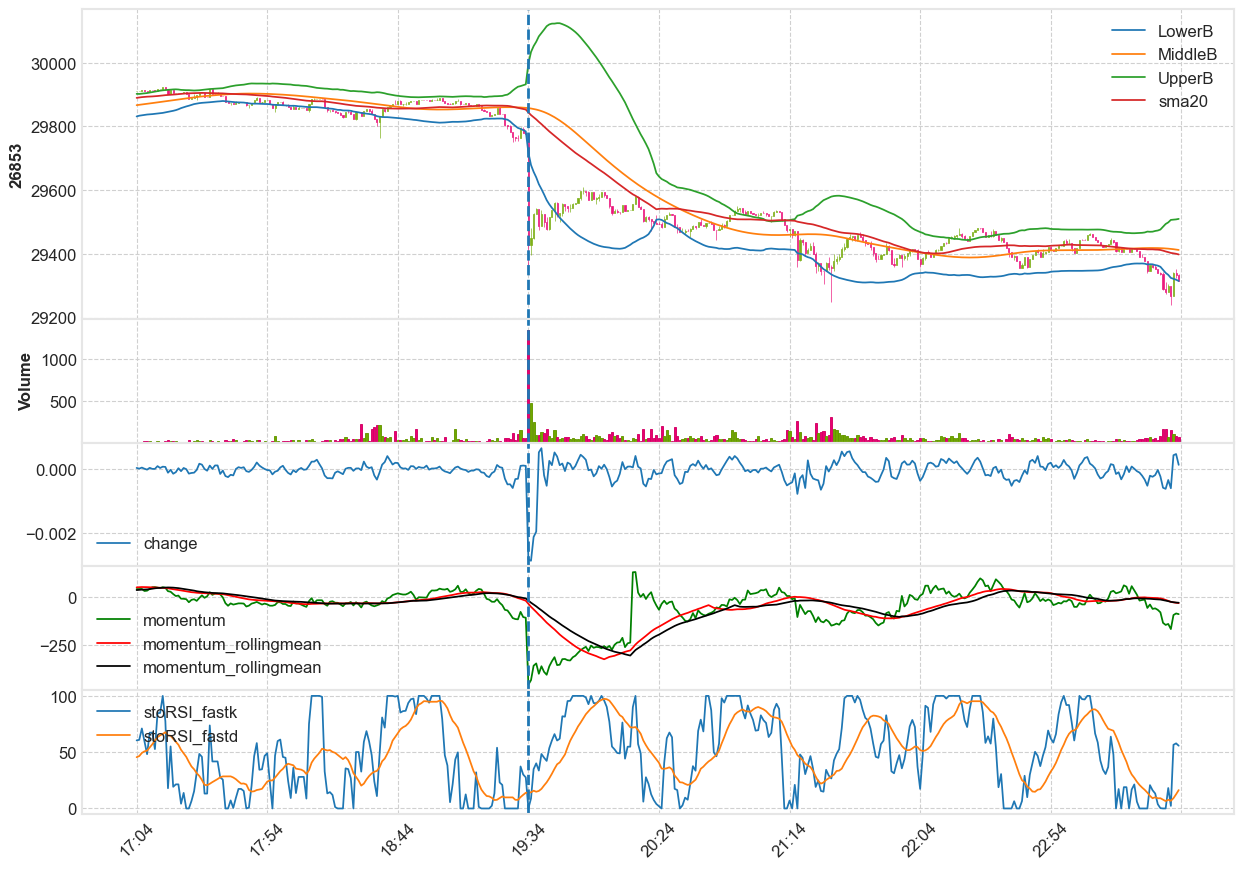

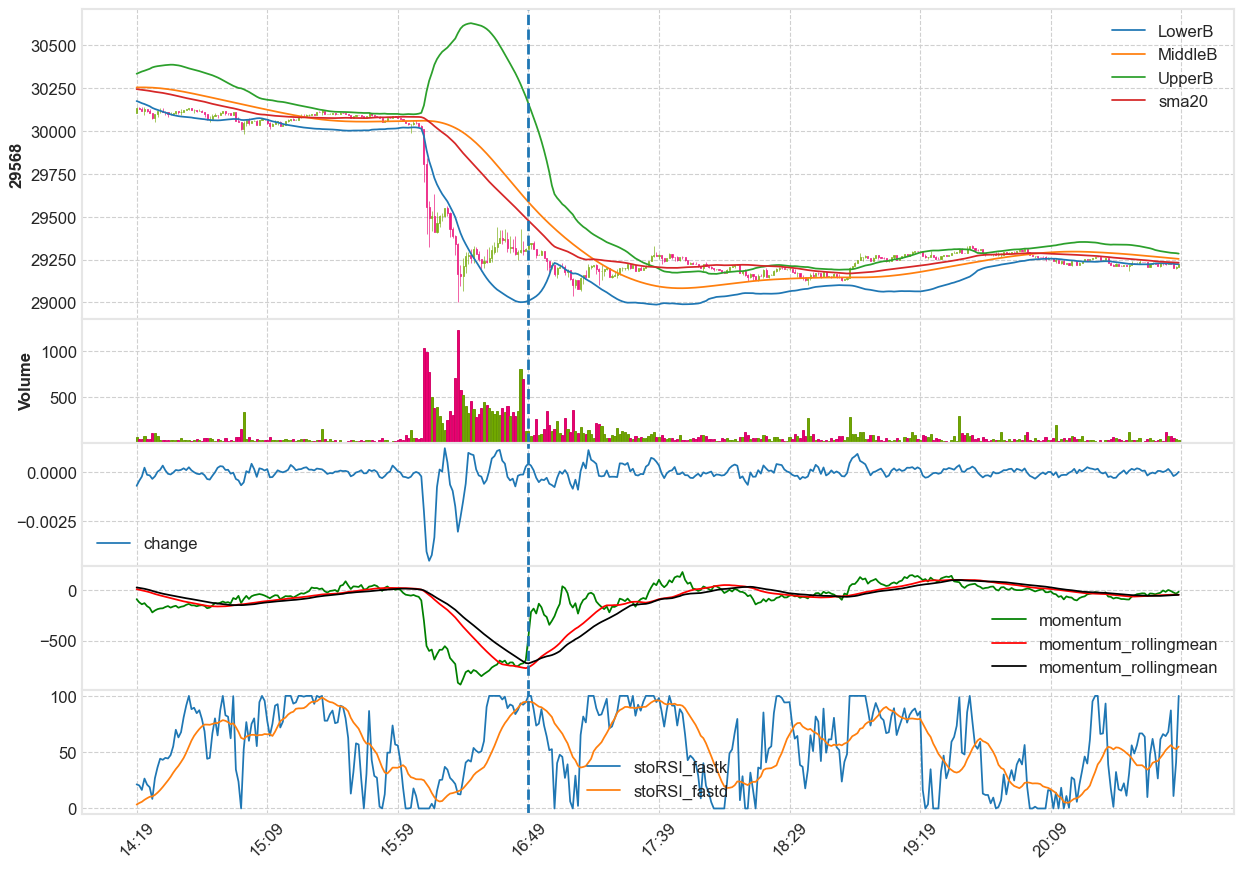

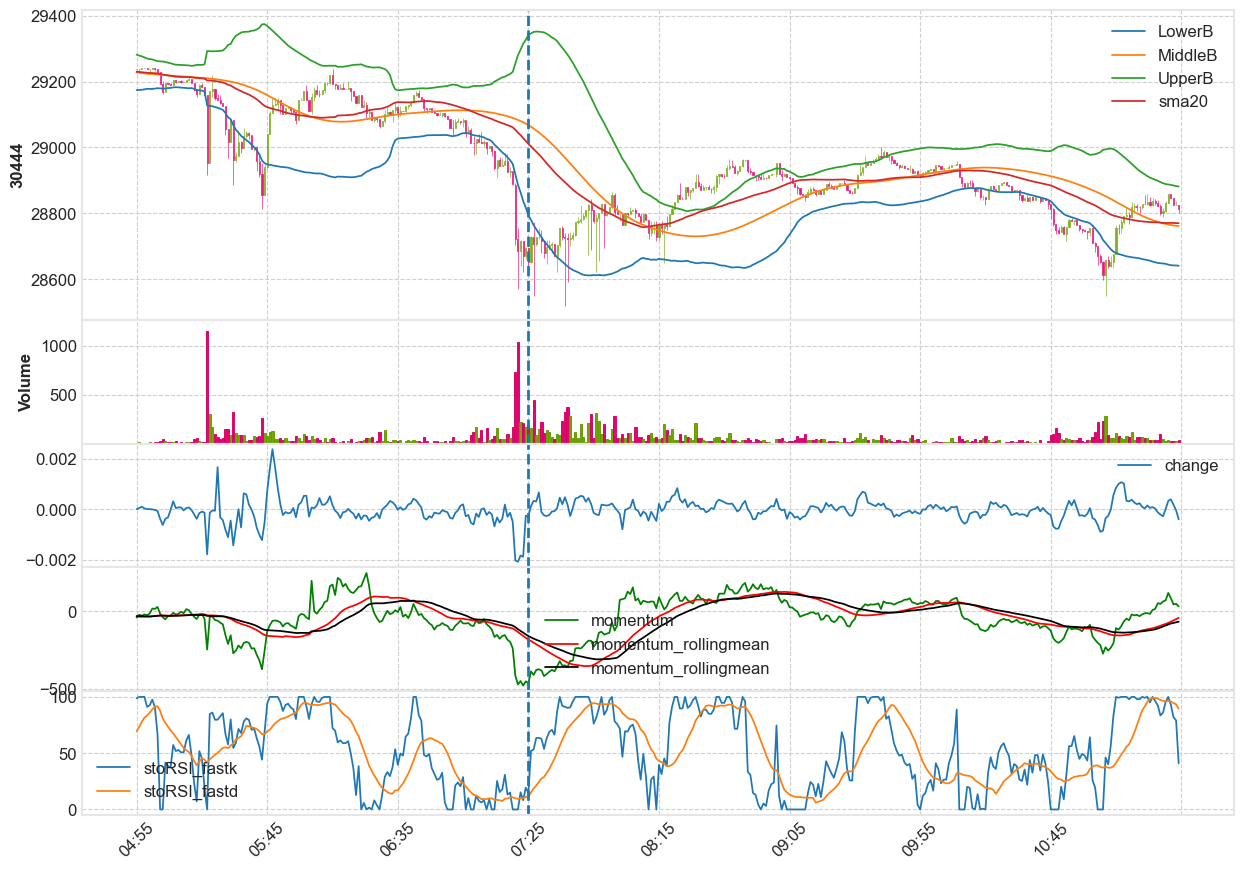

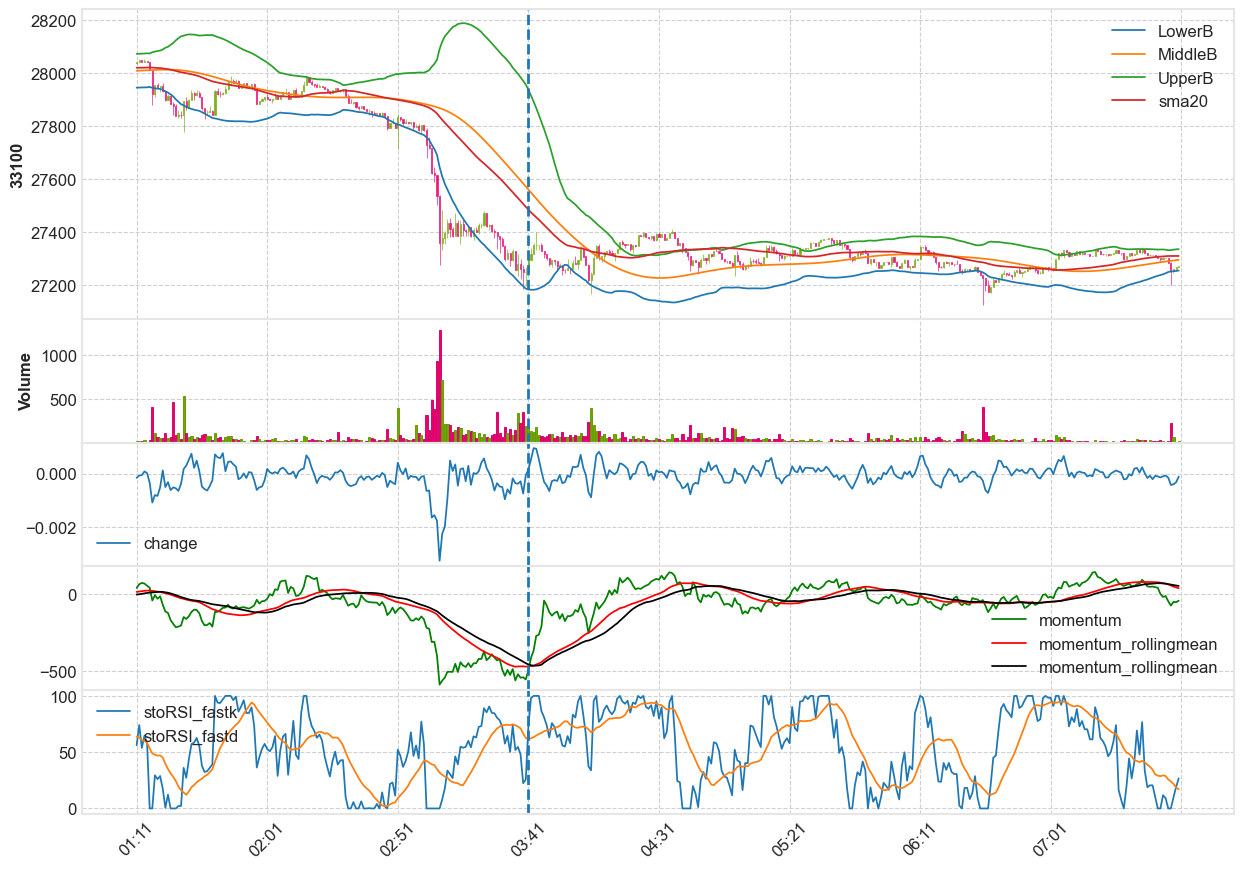

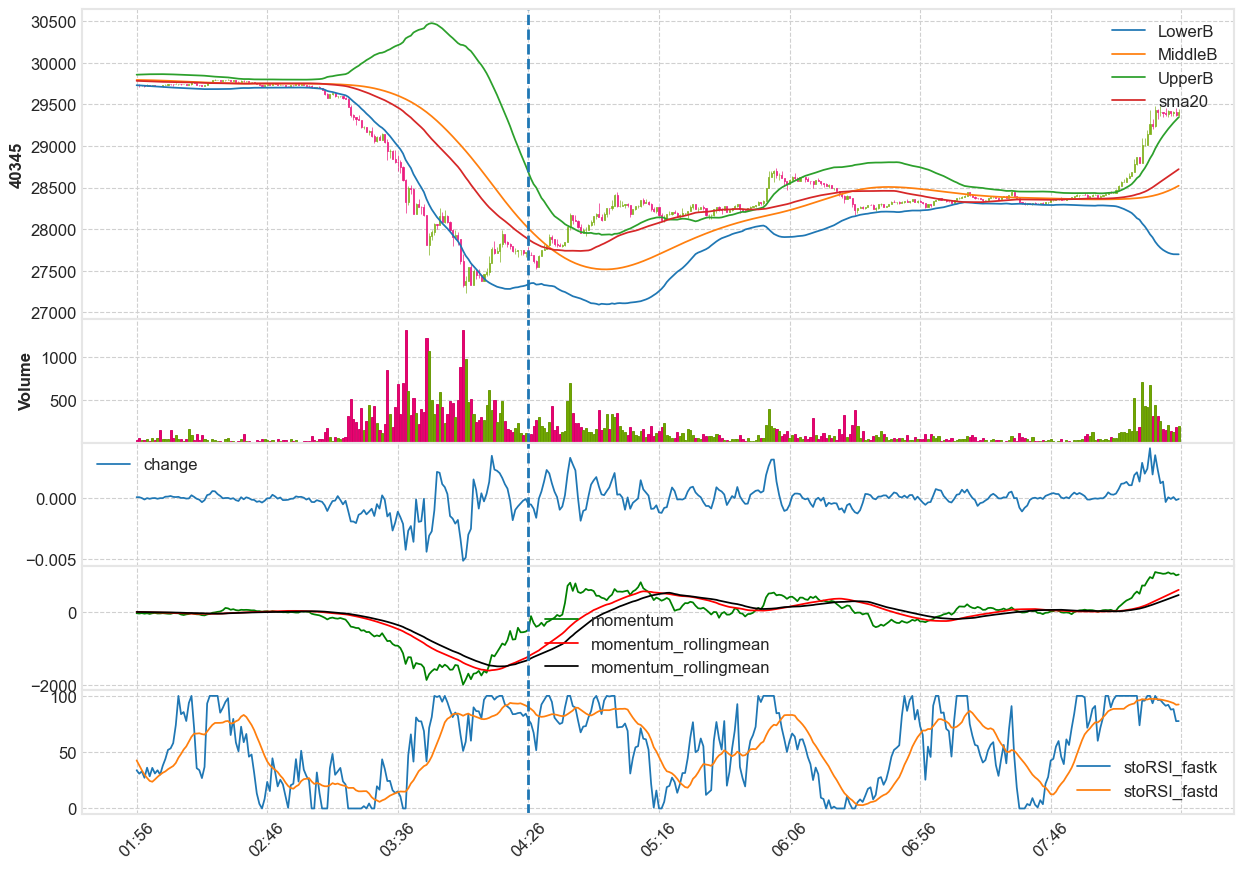

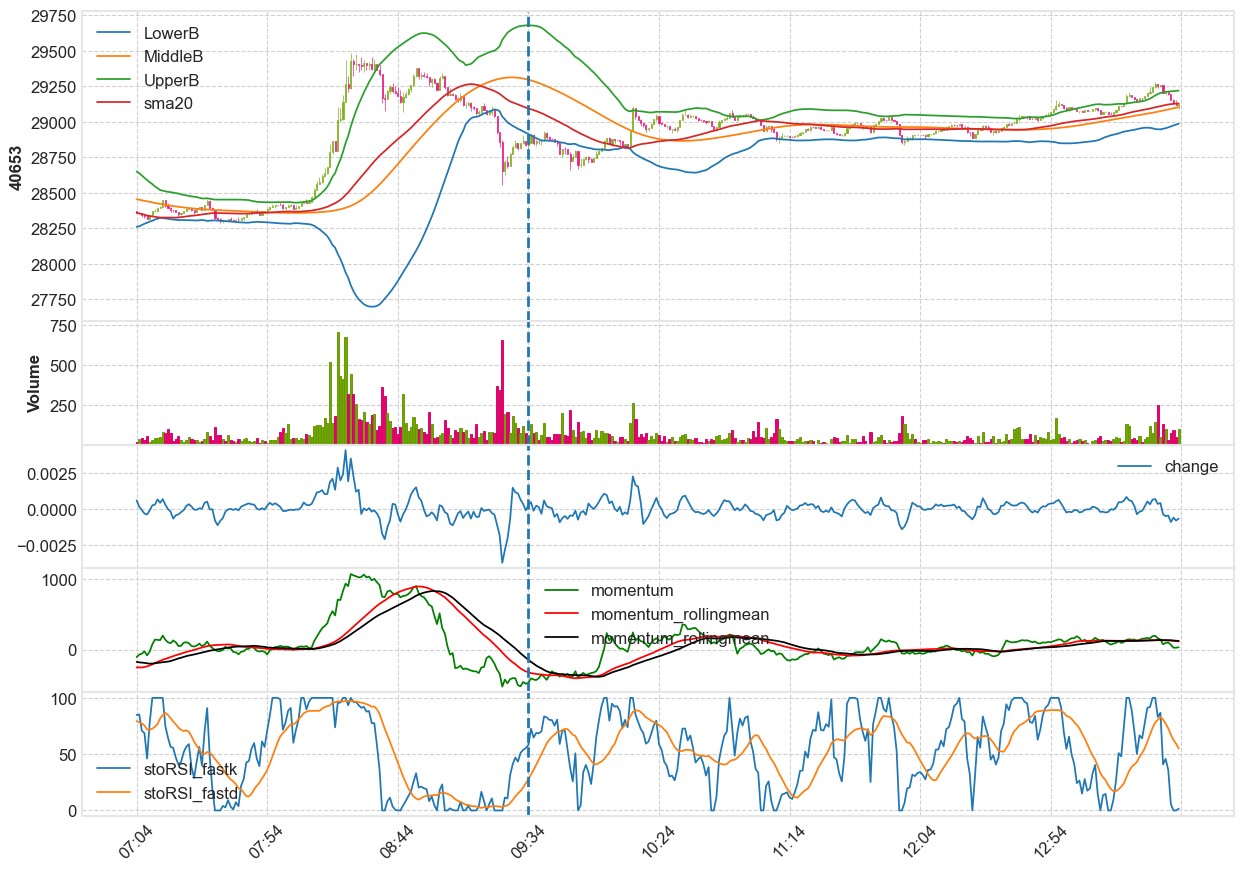

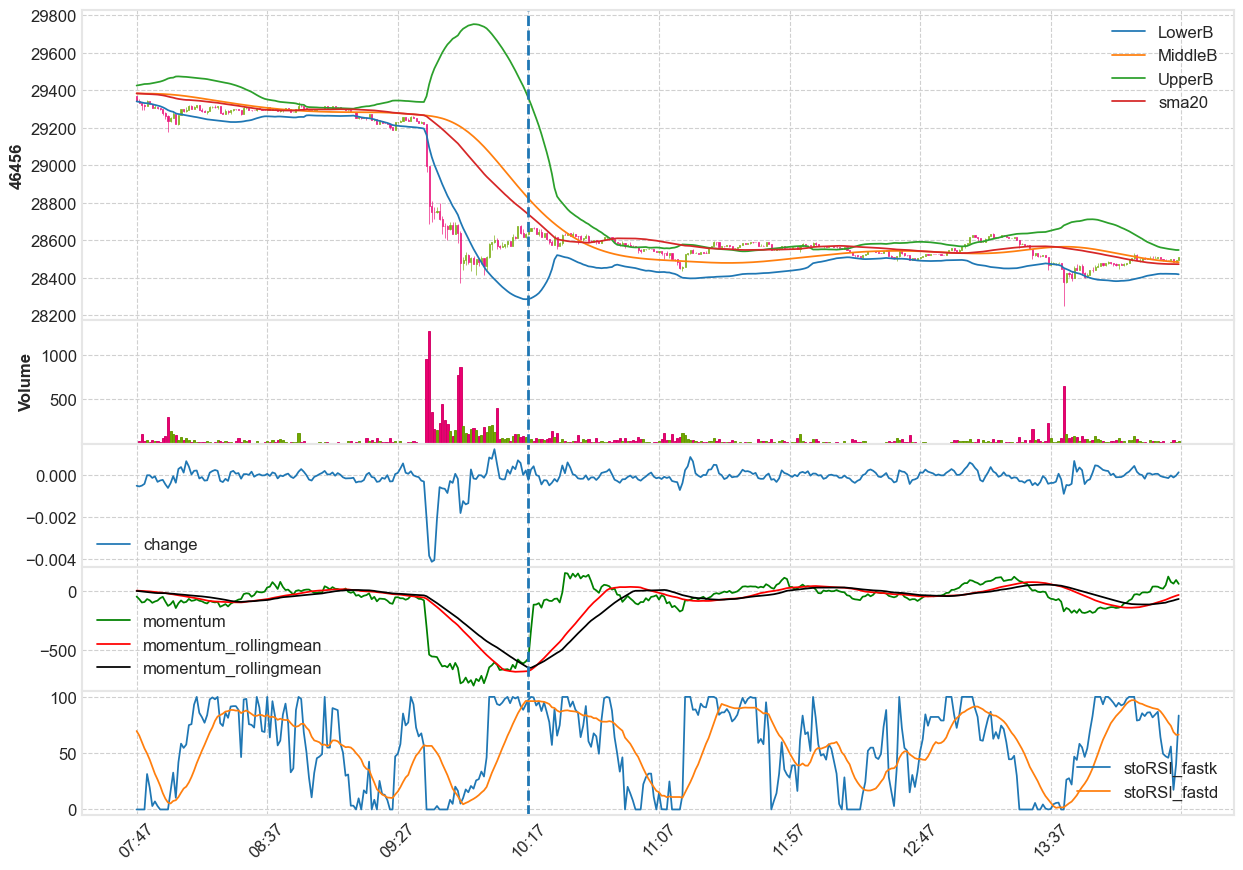

CPU times: total: 11.7 s
Wall time: 16.3 s


In [240]:
%%time

for inddex_of_frame in potential_candidates[:-1][(np.diff( potential_candidates )>1) & (np.diff( potential_candidates )>50)][6:14]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    my_vlines=[dfmpl.iloc[inddex_of_frame].name]
    my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper.iloc[lowerlim:upperlim],label="UpperB"),
             mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
             mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
             mpf.make_addplot(momen.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
              mpf.make_addplot(momen_rolling.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean",color="r",secondary_y=False),
              mpf.make_addplot(momen_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean",color="k",secondary_y=False),
             mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd")
             ]
    fig, axlist = mpf.plot(dfmpl.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for ax in axlist:
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--')
    mpf.show()

In [145]:
from plotting import plot_profits

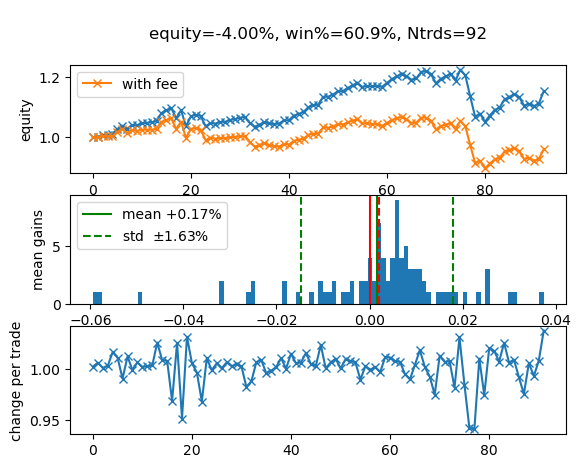

array([<Axes: title={'center': '\nequity=-4.00%, win%=60.9%, Ntrds=92\n'}, ylabel='equity'>,
       <Axes: ylabel='mean gains'>, <Axes: ylabel='change per trade'>],
      dtype=object)

In [146]:
plot_profits(collated_data[:,2])

In [72]:
%%time
#threshold=-0.0022
collated_data_list = []
all_locs = []
for dfmpl,tickerpair,_ in tqdm.tqdm(dfmpl_list[:]):
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
    vol = (dfmpl.Volume*dfmpl.Open).values
    per_threshold = np.percentile(v,0.5)
    vol_threshold = np.percentile(vol,99.5)
    a1=np.where(v<per_threshold)[0]
    a2=np.diff(a1)
    a3=np.where(a2==1)
    def validate_df(loc):
        df_ = dfmpl.iloc[loc:loc+2]
        v0,v1 = (df_.Open*df_.Volume).values
        if v0>vol_threshold and v1>vol_threshold:
            return True
        return False
    
    if len(a3)==0: continue
    locs=a1[a3] 
    if len(locs)==0: continue
    collected_locs = [loc for loc in locs if validate_df(loc) and loc<(190000-5)]
    collated_data = np.asarray([v[loc:loc+5] for loc in collected_locs])
    if len(collated_data)==0: continue
    #print(tickerpair,len(collated_data),[loc for loc in locs if validate_df(loc)])
    [all_locs.append(loc)for loc in collected_locs]
    collated_data_list.append(collated_data)
    #len(locs)
collated_data = np.vstack(collated_data_list)
collated_data.shape

100%|████████████████████████████████████████████████████████████████████████████████| 347/347 [00:14<00:00, 24.34it/s]

CPU times: total: 9.33 s
Wall time: 14.3 s


(13384, 5)

In [75]:
np.product(collated_data[:,2]+1-0.003)

3.66516746260094e-23

# trading implementation / algo

- subscribe to all data using websockets
- within each websocket instance, fetch data
- maintain a list of previous 2 candles
- once the current candle is determined to be changed, pop the list and append the new candle
    - then apply algorithm onto this list,
    - if criteria passed, send to master_trader.

In [23]:
import asyncio
from binance import AsyncClient, BinanceSocketManager
from binance.enums import *
import time
import datetime
from collections import Counter
import pickle

In [ ]:
master_list=[0 for _ in subset_symbols[:]]
async def main(symbol='BNBBTC',idd=0):
    global master_list
    #time.sleep(idd*)
    await asyncio.sleep(idd*0.25)
    client = await AsyncClient.create()
    bm = BinanceSocketManager(client) 
    ts = bm.kline_socket(symbol, interval=KLINE_INTERVAL_1MINUTE) 
    print(f"sub{idd}",end=" ")
    prev="0000"
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            #print(res)
            if res["e"]=="error":
                print(str(datetime.datetime.now())[11:-4],res)
                raise Exception(res)
            #print(res["k"]["s"],str(res["E"])[6:-3],str(res["k"]["T"])[6:-3],end="  ")
            master_list[idd]=str(res["k"]["T"])[6:-3]
            if idd==0:
                if prev != str(res["k"]["T"])[6:-3]:
                    print(str(datetime.datetime.now())[11:-4],master_list[-3:],Counter(master_list))
                    prev = str(res["k"]["T"])[6:-3]
    await client.close_connection()

In [ ]:
loop = asyncio.get_event_loop()
#loop.run_until_complete(main())
for idd,s in enumerate(subset_symbols[:]):
    asyncio.run_coroutine_threadsafe(main(s+"USDT",idd), loop)
    #time.sleep(0.4)